#Predicción de irradiación solar

La **predicción de la potencia de salida de los sistemas solares** es necesaria para el buen funcionamiento de la red eléctrica o para la gestión óptima de los flujos de energía que se producen en el sistema solar. Antes de pronosticar la potencia de los sistemas solares, es **esencial la predicción de la irradiación solar.**



#Metodología

![metodologia](https://drive.google.com/uc?export=view&id=1WTCNJ3kc3wT_erNxbgNbR_gCJbfP5DbS)

#Redes neuronales para predicción de series de tiempo

Los algoritmos de predicción de series temporales encuentran **patrones de comportamiento** en el tiempo.

Las **Redes Neuronales Artificiales (RNA)** son los métodos de predicción de irradiación solar más utilizados. El amplio uso de las **RNA** puede explicarse por la mejora de la capacidad de cálculo, la gran disponibilidad de almacenamiento y la mejora de la precisión conseguida por diferentes **arquitecturas de RNA**. Alrededor del **79%** de los métodos utilizados en la previsión meteorológica se basan en redes neuronales y se han desarrollado **estructuras de redes neuronales especializadas** para series temporales.

#Red neuronal recurrente
![LSTM_cell](https://drive.google.com/uc?export=view&id=1Ysx4DH5NQGiHxBc-M15l4EDhocq9APD0)

#Redes neuronales tipo Long short-term memory (LSTM)

![LSTM_cell](https://drive.google.com/uc?export=view&id=1nvdmET_5ZMceZ2KTpdKEEgWs6Z78jrK6)

Diagrama de una unidad de red LSTM (*LSTM unit*). La unidad está compuesta por cuatro neuronas, cada una de las cuales recibe como entrada el estado actual $x_t$ y el estado anterior $h_{t-1}$. La puerta de entrada puede habilitar o deshabilitar el estado de la neurona de entrada que genera el estado $c_t$, que tiene un autobucle (*self-loop*) lineal representado por el cuadrado negro. La puerta de olvido controla el peso del autobucle. La puerta de salida puede activar o desactivar el estado de la unidad $h_t$.

#Arquitectura tipo codificador-decodificador (Encoder-Decoder)

![encoder_decoder](https://drive.google.com/uc?export=view&id=1zfM6mz_plpHST2wHHD5nUB8IGQnkgxWr)

El codificador crea una representación interna C. El decodificador transforma C en el vector de salida correspondiente.

#Secciones

[1. Importar librerías](#import_librerias)

[2. Cargar bases de datos](#cargar_datos)

[3. Modelo de predicción](#modelos)

[4. Retos](#retos)

<a name="import_librerias"></a>
#1. Importar librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

In [ ]:
from keras.layers import LSTM, Dense
from keras.models import Sequential
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from time import time

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

<a name="cargar_datos"></a>
#2. Cargar bases de datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


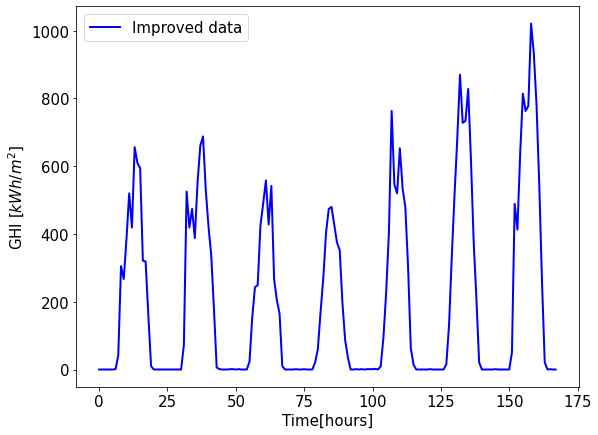

In [ ]:
GHI = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML in PV systems/GHI_sa.csv')

plt.figure()
plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(GHI[0:24*7],'b', label='Improved data', linewidth=2)
plt.legend(loc='best', fontsize=15)
plt.xlabel("Time[hours]", fontsize=15)
plt.xticks(size=15)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=15)
plt.yticks(size=15)
# plt.savefig('/figure.pdf', format='pdf', dpi=300)
plt.show()

In [ ]:
GHI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175200 entries, 0 to 175199
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       175200 non-null  float64
dtypes: float64(1)
memory usage: 1.3 MB


<a name="modelos"></a>
#3. Forecasting con redes LSTM

In [ ]:
# dividir el vector de entrada en muestras

def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

###3.1 Normalizar y dividir en: entrenamiento, prueba y validación

In [ ]:
from sklearn.preprocessing import StandardScaler

# 2 first years for training
# 1 years for testing
# 1 years for validation

X = np.array(GHI)
scaler = StandardScaler().fit(X.reshape(-1, 1))
X = scaler.transform(X.reshape(-1, 1))
X = X.ravel()

n = 365*24
X_train = X[:n]
X_val = X[n:2*n]
X_test = X[2*n:3*n]

In [ ]:
print(X.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(175200,)
(8760,)
(8760,)
(8760,)


##3.2 Forecasting diario

In [ ]:
# Choose number of input and output steps
# Elegir número de pasos de entrada y salida
n_steps_in_d = 168      # 7 días previos
n_steps_out_d = 24      # predecir siguiente día

# Dividir en muestras
X_t, y_t = split_sequence(X_train, n_steps_in_d, n_steps_out_d)
X_v, y_v = split_sequence(X_val, n_steps_in_d, n_steps_out_d)

print(X_t.shape)
print(y_t.shape)
print(X_v.shape)
print(y_v.shape)

(8569, 168)
(8569, 24)
(8569, 168)
(8569, 24)


In [ ]:
# Resize [muestras, timesteps] a [muestras, timesteps, características]
n_features = 1
X_t = X_t.reshape((X_t.shape[0], X_t.shape[1], n_features))
y_t = y_t.reshape((y_t.shape[0], y_t.shape[1], n_features))
X_v = X_v.reshape((X_v.shape[0], X_v.shape[1], n_features))
y_v = y_v.reshape((y_v.shape[0], y_v.shape[1], n_features))

print(X_t.shape)
print(y_t.shape)
print(X_v.shape)
print(y_v.shape)

(8569, 168, 1)
(8569, 24, 1)
(8569, 168, 1)
(8569, 24, 1)


###3.2.1 Entrenando model: 12 neuronas en encoder y decoder

In [ ]:
# definir el modelo

# encoder
model_d = Sequential()
model_d.add(LSTM(12, input_shape=(n_steps_in_d, n_features)))
model_d.add(RepeatVector(n_steps_out_d))

# decoder
model_d.add(LSTM(12, return_sequences=True))
model_d.add(TimeDistributed(Dense(1)))
model_d.compile(optimizer='adam', loss='mse')

# entrenar the model
start = time()
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model_d.fit(X_t, y_t, epochs=100, batch_size=128, verbose=1,
           validation_data=(X_v, y_v), callbacks=[early_stopping])
print("El modelo tardó %.2f segundos en entrenar."% (time() - start)) 

Epoch 1/100
67/67 [==============================] - 27s 97ms/step - loss: 1.0245 - val_loss: 0.8652
Epoch 2/100
67/67 [==============================] - 5s 79ms/step - loss: 0.8084 - val_loss: 0.5345
Epoch 3/100
67/67 [==============================] - 5s 79ms/step - loss: 0.4866 - val_loss: 0.3408
Epoch 4/100
67/67 [==============================] - 5s 80ms/step - loss: 0.3221 - val_loss: 0.2552
Epoch 5/100
67/67 [==============================] - 5s 79ms/step - loss: 0.2499 - val_loss: 0.2144
Epoch 6/100
67/67 [==============================] - 5s 79ms/step - loss: 0.2148 - val_loss: 0.1984
Epoch 7/100
67/67 [==============================] - 5s 80ms/step - loss: 0.1994 - val_loss: 0.1892
Epoch 8/100
67/67 [==============================] - 5s 80ms/step - loss: 0.1925 - val_loss: 0.1767
Epoch 9/100
67/67 [==============================] - 5s 79ms/step - loss: 0.1804 - val_loss: 0.1732
Epoch 10/100
67/67 [==============================] - 5s 80ms/step - loss: 0.1753 - val_loss: 0.168

In [ ]:
model_d.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12)                672       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 24, 12)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 12)            1200      
_________________________________________________________________
time_distributed (TimeDistri (None, 24, 1)             13        
Total params: 1,885
Trainable params: 1,885
Non-trainable params: 0
_________________________________________________________________


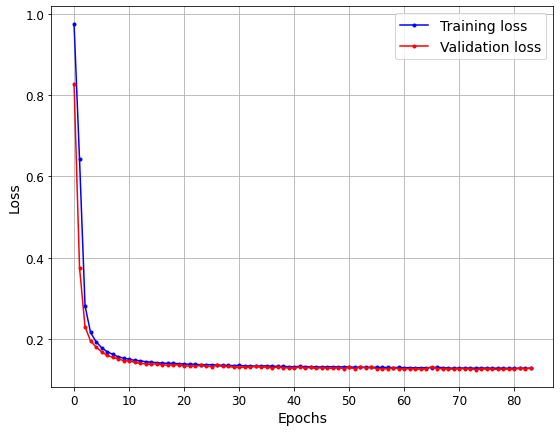

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)), loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)), val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    # plt.axis([1, len(history.epoch), 0.1, 0.15])
    # plt.axis([1, len(history.epoch), min(history.history["val_loss"]), max(history.history["val_loss"])])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

##3.3 Forecasting diario en conjunto de prueba

In [ ]:
# Forecasting en conjunto de prueba
X_test_, y_test_ = split_sequence(X_test, n_steps_in_d, n_steps_out_d)
y_test = scaler.inverse_transform(y_test_)

print(X_test_.shape)
print(y_test.shape)

(8569, 168)
(8569, 24)


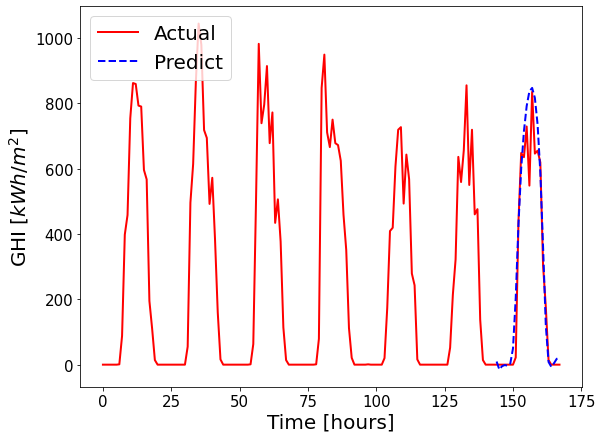

Root mean square error:  85.61396968753672
Mean absolute error:  50.78585623701414
R-Squared:  0.9221561583277509


In [ ]:
predict = 24*8
x_input = X_test_[predict].reshape((1, n_steps_in_d, n_features))
yhat_norm_d = model_d.predict(x_input, verbose=0)
yhat_d = scaler.inverse_transform(yhat_norm_d)
yhat_d = yhat_d[0]

var = scaler.inverse_transform(X_test)
actual = y_test[predict]
prev = var[predict-24*6:predict]
prev = np.hstack((prev,actual))

time = np.arange(24*7)
plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(prev,'r',  label='Actual', linewidth=2)
plt.plot(time[24*6:], yhat_d.ravel(),'b--',  label='Predict', linewidth=2)
plt.legend(loc='upper left', fontsize=20)
plt.xlabel("Time [hours]", fontsize=20)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=20)
plt.yticks(size=15)
plt.xticks(size=15)
# plt.savefig('Figuras_Informe/predic_1_day_01012012.png', format='png', dpi=300)
plt.show() 

rmse = np.sqrt(mean_squared_error(actual, yhat_d))
mae = mean_absolute_error(actual, yhat_d)
r2 = r2_score(actual, yhat_d)

print('Root mean square error: ', rmse)
print('Mean absolute error: ', mae)
print('R-Squared: ', r2)

<a name="retos"></a>
#4. Retos
1. Entrenar diferentes arquitecturas (número de neuronas, días de entrada).
2. Construir un modelo para predecir la irradiación de una semana.
3. Probar con más datos (recuede que usamos 2 años para entrenamiento, 1 año para prueba, y un año para validación).

![encoder_decoder](https://drive.google.com/uc?export=view&id=1g64xhbpqZRVs4__z68SczgsDsj0hthgN)
